In [2]:
from dataset import MNISTDataset
import torch
from torchvision import transforms

In [5]:
dataset = MNISTDataset("MNIST/train.csv", transforms.ToTensor())

In [6]:
len(dataset)

42000

In [3]:
import torch
import torch.nn as nn
from model import VAE
import os
from torch.utils.data import DataLoader
from dataset import MNISTNoiseDataset
from torchvision import transforms
from collections import defaultdict

batch_size = 64
encoder_layer_sizes = [784,256]
latent_size = 2
decoder_layer_sizes = [256,784]
conditional=True
learning_rate = 0.001
epochs=20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = MNISTNoiseDataset(X_file="MNIST/X.pt", y_file = "MNIST/y.pt")
data_loader = DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=True)

def loss_fn(recon_x, x, mean, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(
        recon_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return (BCE + KLD) / x.size(0)

vae = VAE(
    encoder_layer_sizes=encoder_layer_sizes,
    latent_size=latent_size,
    decoder_layer_sizes=decoder_layer_sizes,
    conditional=conditional,
    num_labels=10 if conditional else 0).to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

logs = []

for epoch in range(epochs):
    tracker_epoch = defaultdict(lambda: defaultdict(dict))
    temp_loss = []

    for iteration, (x, y) in enumerate(data_loader):

        x, y = x.to(device), y.to(device)

        if conditional:
            recon_x, mean, log_var, z = vae(x, y)
        else:
            recon_x, mean, log_var, z = vae(x)

        for i, yi in enumerate(y):
            id = len(tracker_epoch)
            tracker_epoch[id]['x'] = z[i, 0].item()
            tracker_epoch[id]['y'] = z[i, 1].item()
            tracker_epoch[id]['label'] = yi.item()

        loss = loss_fn(recon_x, x, mean, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        temp_loss.append(loss.item())

    logs.append(sum(temp_loss)/len(temp_loss))
        
    print(f"Epoch{[epoch + 1]}: Loss = {sum(temp_loss)/len(temp_loss)}")

Epoch[1]: Loss = 175.65999012196627
Epoch[2]: Loss = 144.2285790987755
Epoch[3]: Loss = 140.84165203262864
Epoch[4]: Loss = 139.0680730230369
Epoch[5]: Loss = 137.86018140493826
Epoch[6]: Loss = 136.94948483819832
Epoch[7]: Loss = 136.19787396760472
Epoch[8]: Loss = 135.60054393518644
Epoch[9]: Loss = 135.06015322378963
Epoch[10]: Loss = 134.63064511326712
Epoch[11]: Loss = 134.25197336553984
Epoch[12]: Loss = 133.90063600815958
Epoch[13]: Loss = 133.62318038359805
Epoch[14]: Loss = 133.36503750875116
Epoch[15]: Loss = 133.13910990908084
Epoch[16]: Loss = 132.90559758806157
Epoch[17]: Loss = 132.70840766477076
Epoch[18]: Loss = 132.58046817634386
Epoch[19]: Loss = 132.33786015387176
Epoch[20]: Loss = 132.1994229785565


In [4]:
torch.save(logs, "lossData/y_clean_loss.pt")

In [350]:
total_X = []
total_y = []
for i in torch.arange(10):
    for j in range(4200):
        total_y.append(i)
        z = torch.randn(1,2)
        total_X.append(vae.inference(z.to(device), torch.tensor([i]).to(device)).reshape(1,1,28,28))

In [351]:
X_aug = (torch.cat(total_X)*255).to(torch.float32)
y_aug = torch.tensor(total_y).to(torch.int64)

In [315]:
torch.save(X_aug, "augmentedData/X_20_aug.pt")
#torch.save(y_aug, "augmentedData/y_aug.pt")

In [211]:
z = torch.rand((1,2))

In [212]:
generated_image = vae.inference(z.to(device), torch.tensor([3]).to(device)).reshape(28,28)

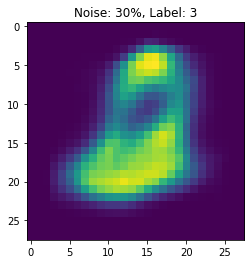

In [213]:
import matplotlib.pyplot as plt
plt.title("Noise: 30%, Label: 3")
plt.imshow(generated_image.cpu().detach().numpy())

In [175]:
torch.load("augmentedData/y_aug.pt")

tensor([0, 0, 0,  ..., 9, 9, 9])

In [284]:
data = torch.load("MNIST/X.pt")
data.shape

torch.Size([42000, 1, 28, 28])

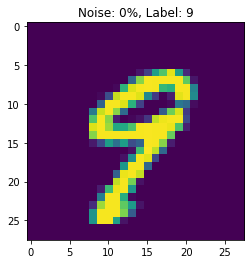

In [298]:
plt.title("Noise: 0%, Label: 9")
plt.imshow(data[11][0].cpu().detach().numpy())

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
y_clean = torch.load("lossData/y_clean_loss.pt")
y_10 = torch.load("lossData/y_10_loss.pt")
y_20 = torch.load("lossData/y_20_loss.pt")
y_30 = torch.load("lossData/y_30_loss.pt")
y_40 = torch.load("lossData/y_40_loss.pt")
x = np.arange(20)

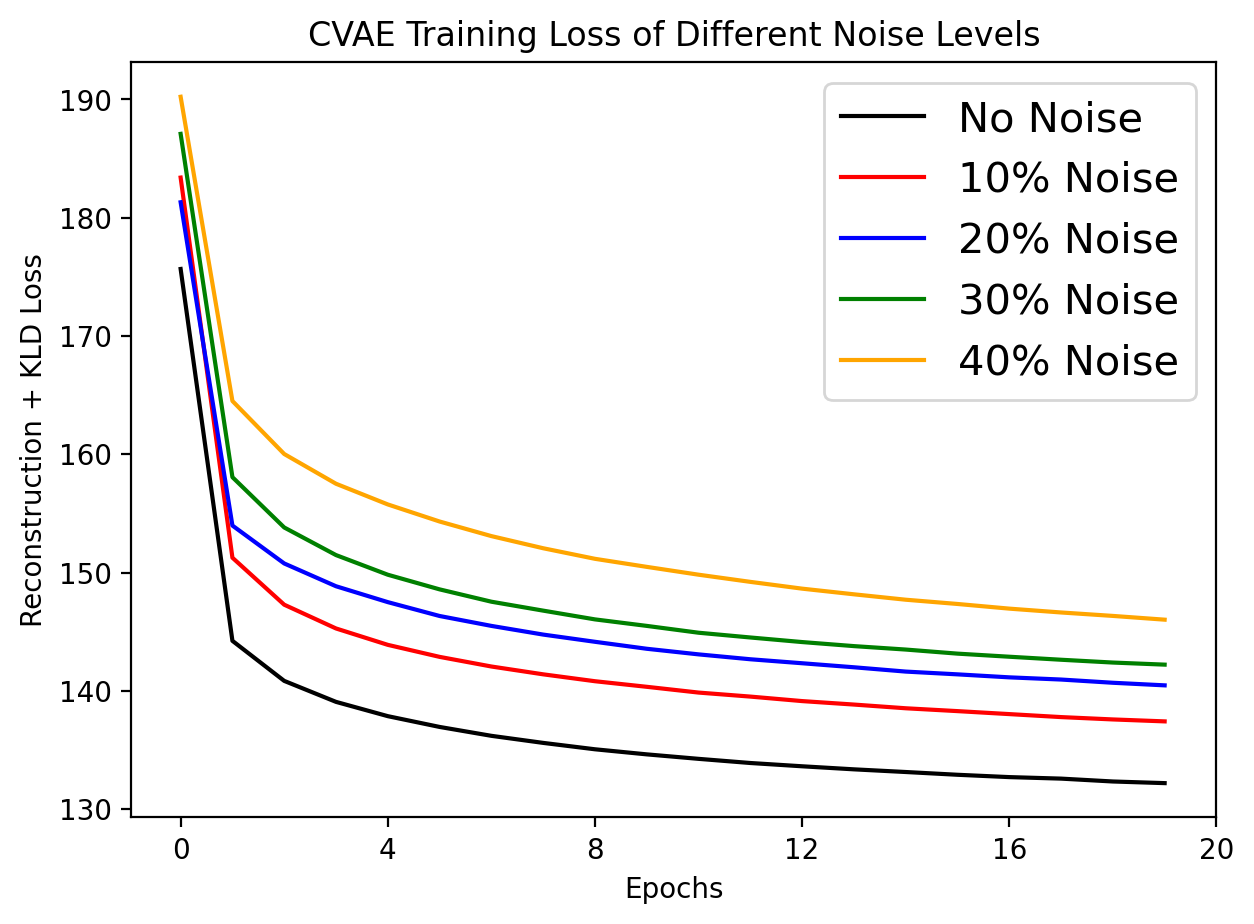

In [3]:
fig, ax = plt.subplots()
ax.plot(x, y_clean, linestyle='-', color='black', label='No Noise')
ax.plot(x, y_10, linestyle='-', color='red', label='10% Noise')
ax.plot(x, y_20, linestyle='-', color='blue', label='20% Noise')
ax.plot(x, y_30, linestyle='-', color='green', label='30% Noise')
ax.plot(x, y_40, linestyle='-', color='orange', label='40% Noise')
ax.legend(bbox_to_anchor=(1, 1), fontsize="15")
ax.set_title('CVAE Training Loss of Different Noise Levels')
ax.set_xlabel('Epochs')
ax.set_ylabel('Reconstruction + KLD Loss')
ax.set_xticks(np.arange(0,21,4))
fig.set_size_inches(7, 5)
fig.set_dpi(200)
plt.show()

In [340]:
X = torch.load("MNIST/X.pt").cpu().detach().numpy()
y = torch.load("MNIST/y.pt").cpu().detach().numpy()

In [341]:
from sklearn.decomposition import PCA
X = X.reshape(42000,-1)
X = X / 255.0  # Normalize the data
p = np.random.permutation(len(X))
X = X[p]
y = y[p]
data_1000 = X[0:1000,:]
labels_1000 = y[0:1000]

In [342]:
from sklearn.manifold import TSNE

# Perform t-SNE on the data
tsne = TSNE(n_components=2, perplexity=50, random_state=0)
X_tsne = tsne.fit_transform(data_1000)

In [343]:
import pandas as pd
import seaborn as sns
tsne_data = np.vstack((X_tsne.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=["Dim_1", "Dim_2", "label"])

/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


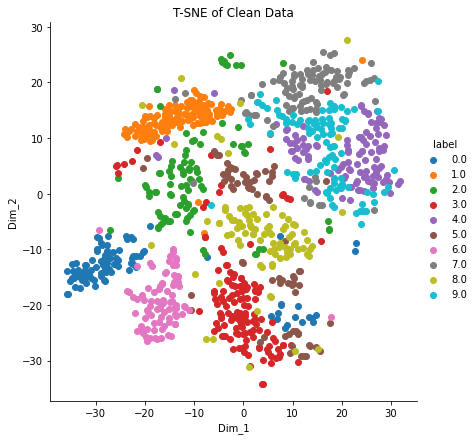

In [344]:
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()
plt.title("T-SNE of Clean Data")
plt.show()

In [379]:
X_clean = torch.load("MNIST/X.pt")
y_noise = torch.load("noisyData/y_10.pt")
X_10 = torch.load("augmentedData/X_10_aug.pt")
y_10 = torch.load("augmentedData/y_aug.pt")

In [380]:
X_10.shape

torch.Size([42000, 1, 28, 28])

In [381]:
y_10.shape

torch.Size([42000])

In [382]:
X_10 = X_10.detach()
X_10.requires_grad= False

In [383]:
y_10 = y_10.detach()
y_10.requires_grad = False

In [384]:
full_X = torch.cat((X_clean, X_10.cpu()))
full_y = torch.cat((y_noise, y_10.cpu()))
# full_X = X_10
# full_y = y_10

In [385]:
full_X.shape

torch.Size([84000, 1, 28, 28])

In [386]:
torch.save(full_X, "fullData/X_10_full.pt")
torch.save(full_y, "fullData/y_10_full.pt")

In [160]:
dataX = torch.load("fullData/X_10_full.pt")
datay = torch.load("fullData/y_10_full.pt")

In [162]:
datay.shape

torch.Size([84000])

In [345]:
full_y

tensor([8, 0, 1,  ..., 9, 9, 9])